Using workflow column: Where do you primarily use AI in your development workflow? (Select all that apply)
Using helpfulness column: On a scale of 1 to 5, how would you rate the overall helpfulness of AI in your daily development tasks?


/var/folders/k7/nk16v26j38j_mcwrggjp5tpc0000gn/T/ipykernel_93473/2167689102.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


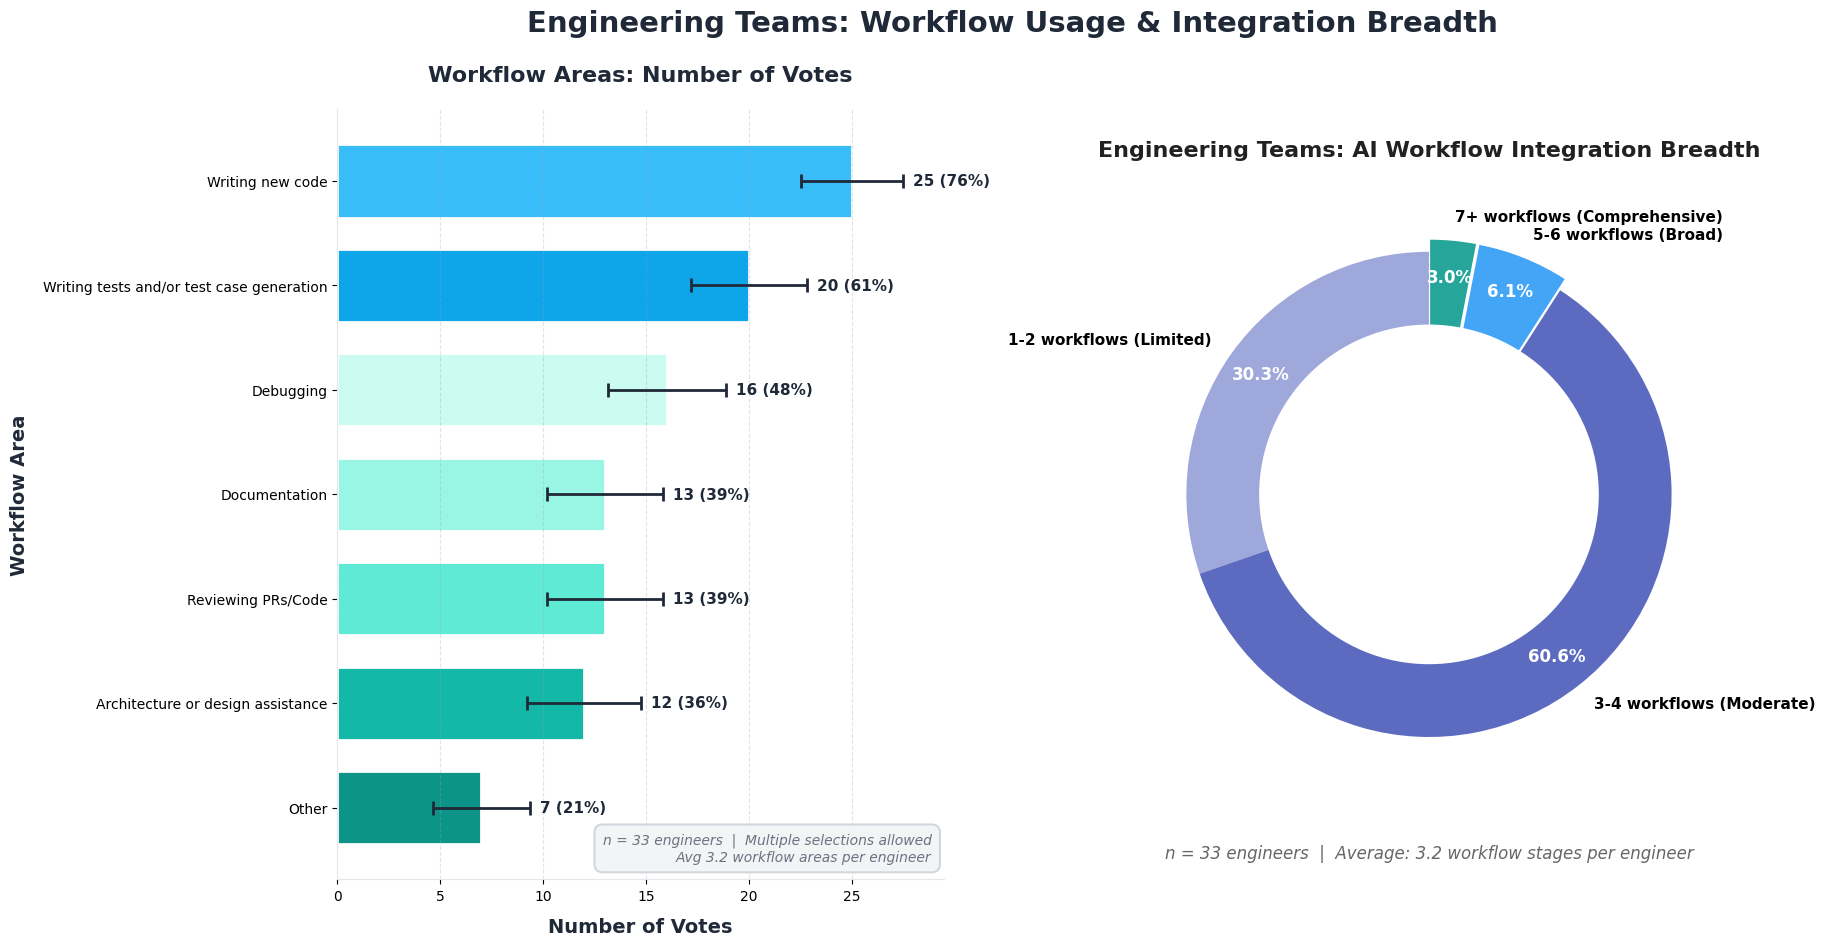


ENGINEERING TEAMS - AI WORKFLOW USAGE & HELPFULNESS ANALYSIS

📊 Sample Size: 33 engineers

🔄 Workflow Usage Breakdown (Number of Votes per Area):
Rank   Workflow Area                                      Count    % of Engineers 
1      Writing new code                                   25       75.8          %
2      Writing tests and/or test case generation          20       60.6          %
3      Debugging                                          16       48.5          %
4      Reviewing PRs/Code                                 13       39.4          %
5      Documentation                                      13       39.4          %
6      Architecture or design assistance                  12       36.4          %
7      Other                                              7        21.2          %

📊 Correlation Analysis:
   • Pearson Correlation: 0.5267
   • Strength: Strong positive correlation
   • P-value: 0.0016 (Significant)

✨ Key Statistics:
   • Total workflow selections: 10

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load the data
df = pd.read_csv('../responses.csv')

# Filter out non-engineering teams
teams_to_exclude = ['Customer Solutions', 'Customer Support', 'Pre-Sales']
df_filtered = df[~df['Which team are you a part of?'].isin(teams_to_exclude)].copy()

# Get column names
workflow_col = df_filtered.columns[14]  # Column O - Where they use AI
helpfulness_col = df_filtered.columns[15]  # Column P - Helpfulness rating

print(f"Using workflow column: {workflow_col}")
print(f"Using helpfulness column: {helpfulness_col}")

# Create numeric mapping for helpfulness
rating_values = {
    'Extremely Helpful': 5,
    'Very Helpful': 4,
    'Moderately Helpful': 3,
    'Slightly Helpful': 2,
    'Not Helpful': 1
}

df_filtered['rating_numeric'] = df_filtered[helpfulness_col].map(rating_values)

# Parse workflow usage and count workflow areas per person
all_workflows = []
workflow_counts_per_person = []

for idx, response in df_filtered[workflow_col].items():
    if pd.notna(response):
        workflows = [wf.strip() for wf in response.split(',')]
        all_workflows.extend(workflows)
        workflow_counts_per_person.append(len(workflows))
    else:
        workflow_counts_per_person.append(0)

# Add workflow count per person to dataframe
df_filtered['num_workflow_areas'] = workflow_counts_per_person

# Calculate total engineers
total_engineers = len(df_filtered)

# Categorize workflow counts for donut chart
def categorize_workflow_count(count):
    if count == 0:
        return '0 workflows (Not using AI)'
    elif count <= 2:
        return '1-2 workflows (Limited)'
    elif count <= 4:
        return '3-4 workflows (Moderate)'
    elif count <= 6:
        return '5-6 workflows (Broad)'
    else:
        return '7+ workflows (Comprehensive)'

df_filtered['workflow_category'] = df_filtered['num_workflow_areas'].apply(categorize_workflow_count)

# Count engineers in each category
category_order = [
    '0 workflows (Not using AI)',
    '1-2 workflows (Limited)',
    '3-4 workflows (Moderate)',
    '5-6 workflows (Broad)',
    '7+ workflows (Comprehensive)'
]

category_counts = df_filtered['workflow_category'].value_counts().reindex(category_order, fill_value=0)
category_counts = category_counts[category_counts > 0]
active_categories = category_counts.index.tolist()

# Calculate key metrics for donut chart
broad_users = category_counts.get('5-6 workflows (Broad)', 0) + category_counts.get('7+ workflows (Comprehensive)', 0)
broad_pct = (broad_users / total_engineers * 100)

workflow_counts = Counter(all_workflows)

# Convert to DataFrame
workflow_df = pd.DataFrame(workflow_counts.items(), columns=['Workflow', 'Count'])
workflow_df = workflow_df.sort_values('Count', ascending=True)
workflow_df['Percentage'] = (workflow_df['Count'] / len(df_filtered)) * 100

# Calculate standard error for workflow proportions (for error bars)
# SEM for proportions: sqrt(p*(1-p)/n)
workflow_df['SEM'] = np.sqrt((workflow_df['Percentage']/100) * (1 - workflow_df['Percentage']/100) / len(df_filtered))
workflow_df['SEM_Count'] = workflow_df['SEM'] * len(df_filtered)  # Convert SEM from proportion to count

# Calculate correlation between helpfulness and number of workflow areas
from scipy import stats

# Filter out rows with missing data
df_correlation = df_filtered.dropna(subset=['rating_numeric', 'num_workflow_areas', helpfulness_col]).copy()

# Calculate correlation
if len(df_correlation) > 1:
    correlation, correlation_pvalue = stats.pearsonr(df_correlation['num_workflow_areas'], df_correlation['rating_numeric'])
else:
    correlation, correlation_pvalue = 0, 1

# Calculate overall stats
avg_rating = df_filtered['rating_numeric'].mean()
avg_workflows = df_filtered['num_workflow_areas'].mean()

# Create figure with 2 subplots
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

# ===== SUBPLOT 1: Workflow Usage Votes (Left) =====
ax1 = fig.add_subplot(gs[0, 0])

# Modern teal/blue gradient colors
teal_gradient = ['#0D9488', '#14B8A6', '#5EEAD4', '#99F6E4', '#CCFBF1', '#0EA5E9', '#38BDF8', '#7DD3FC']
colors_workflow = teal_gradient[:len(workflow_df)]

bars1 = ax1.barh(workflow_df['Workflow'], workflow_df['Count'], 
                 color=colors_workflow, height=0.7, edgecolor='white', linewidth=2,
                 xerr=workflow_df['SEM_Count'], error_kw={'elinewidth': 2, 'ecolor': '#1F2937', 
                 'capsize': 5, 'capthick': 2})

# Add value labels (positioned after error bars)
max_with_error = max(workflow_df['Count'] + workflow_df['SEM_Count']) if len(workflow_df) > 0 else 0
for bar, count, pct, sem_count in zip(bars1, workflow_df['Count'], workflow_df['Percentage'], workflow_df['SEM_Count']):
    label_x = count + sem_count + 0.5
    ax1.text(label_x, bar.get_y() + bar.get_height()/2, 
            f'{int(count)} ({pct:.0f}%)', 
            va='center', fontsize=11, weight='bold', color='#1F2937')

ax1.set_xlabel('Number of Votes', fontsize=14, weight='bold', color='#1F2937', labelpad=10)
ax1.set_ylabel('Workflow Area', fontsize=14, weight='bold', color='#1F2937', labelpad=10)
ax1.set_title('Workflow Areas: Number of Votes', fontsize=16, weight='bold', pad=20, color='#1F2937')
ax1.set_xlim(0, max(max(workflow_df['Count']) + 3, max_with_error + 2))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('#E5E7EB')
ax1.spines['bottom'].set_color('#E5E7EB')
ax1.grid(axis='x', alpha=0.3, linestyle='--', color='#9CA3AF')

# Add note
ax1.text(0.98, 0.02, f'n = {total_engineers} engineers  |  Multiple selections allowed\nAvg {len(all_workflows)/total_engineers:.1f} workflow areas per engineer', 
         transform=ax1.transAxes, ha='right', va='bottom',
         fontsize=10, style='italic', color='#6B7280',
         bbox=dict(boxstyle='round,pad=0.6', facecolor='#F3F4F6', 
                  edgecolor='#D1D5DB', linewidth=1.5, alpha=0.95))

# ===== SUBPLOT 2: Workflow Integration Breadth Donut Chart (Right) =====
ax2 = fig.add_subplot(gs[0, 1])

# Modern, appealing color palette - vibrant gradient from cool to warm
color_map = {
    '0 workflows (Not using AI)': '#E8EAF6',      # Light lavender
    '1-2 workflows (Limited)': '#9FA8DA',         # Soft indigo
    '3-4 workflows (Moderate)': '#5C6BC0',        # Medium blue
    '5-6 workflows (Broad)': '#42A5F5',           # Bright blue
    '7+ workflows (Comprehensive)': '#26A69A'     # Teal green
}

colors = [color_map[cat] for cat in active_categories]

# Create pie chart
wedges, texts, autotexts = ax2.pie(
    category_counts.values,
    labels=active_categories,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 11, 'weight': 'bold'},
    pctdistance=0.85,
    explode=[0.05 if '5-6' in cat or '7+' in cat else 0 for cat in active_categories]
)

# Style percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

# Create donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax2.add_artist(centre_circle)

# Add title
ax2.set_title('Engineering Teams: AI Workflow Integration Breadth', 
              fontsize=16, weight='bold', pad=25, color='#212121')

# Add subtitle
ax2.text(0.5, -0.1, f'n = {total_engineers} engineers  |  Average: {avg_workflows:.1f} workflow stages per engineer', 
         ha='center', transform=ax2.transAxes, fontsize=12, style='italic', color='#666666')

# Overall title
fig.suptitle('Engineering Teams: Workflow Usage & Integration Breadth', 
             fontsize=21, weight='bold', y=0.98, color='#1F2937')

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("\n" + "="*80)
print("ENGINEERING TEAMS - AI WORKFLOW USAGE & HELPFULNESS ANALYSIS")
print("="*80)

print(f"\n📊 Sample Size: {total_engineers} engineers")

print(f"\n🔄 Workflow Usage Breakdown (Number of Votes per Area):")
print(f"{'Rank':<6} {'Workflow Area':<50} {'Count':<8} {'% of Engineers':<15}")
print("="*80)
for i, (_, row) in enumerate(workflow_df.sort_values('Count', ascending=False).iterrows(), 1):
    print(f"{i:<6} {row['Workflow']:<50} {int(row['Count']):<8} {row['Percentage']:<14.1f}%")

print(f"\n📊 Correlation Analysis:")
print(f"   • Pearson Correlation: {correlation:.4f}")
corr_strength = 'Strong' if abs(correlation) > 0.5 else 'Moderate' if abs(correlation) > 0.3 else 'Weak'
sig_text = 'Significant' if correlation_pvalue < 0.05 else 'Not significant'
print(f"   • Strength: {corr_strength} {'positive' if correlation > 0 else 'negative'} correlation")
print(f"   • P-value: {correlation_pvalue:.4f} ({sig_text})")

print(f"\n✨ Key Statistics:")
print(f"   • Total workflow selections: {len(all_workflows)}")
print(f"   • Average workflow areas per engineer: {avg_workflows:.1f}")
print(f"   • Unique workflow areas: {len(workflow_counts)}")
print(f"   • Average helpfulness rating: {avg_rating:.2f}/5.0")
print(f"   • Sample size for correlation: {len(df_correlation)} engineers")

print(f"\n💡 Insights:")
print(f"   • Most popular workflow area: {workflow_df.iloc[-1]['Workflow']} ({int(workflow_df.iloc[-1]['Count'])} votes)")
print(f"   • Least popular workflow area: {workflow_df.iloc[0]['Workflow']} ({int(workflow_df.iloc[0]['Count'])} votes)")
if correlation > 0 and correlation_pvalue < 0.05:
    print(f"   • Engineers who use AI in more workflow areas tend to rate it as more helpful")
elif correlation > 0:
    print(f"   • There appears to be a positive trend between workflow usage and helpfulness")
else:
    print(f"   • No clear correlation between number of workflow areas and helpfulness rating")

print("\n" + "="*80 + "\n")